## Load the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE

## Load and Inspect data

In [2]:
data = pd.read_csv('conversion_data.csv')
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


From the table above, the max value of age is 123, which is abnormal. And we can handle it as outliers.
Let's first check the age above 100.

In [4]:
data.loc[data.age >= 100, :]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


What's the distribution of age after deleting these two observations?

We can see below that the minimum is 17 and the maximum is 79, which is much reasonable. So let's delete these two.

In [5]:
data.age[data.age <= 100].describe()

count    316198.000000
mean         30.569311
std           8.268958
min          17.000000
25%          24.000000
50%          30.000000
75%          36.000000
max          79.000000
Name: age, dtype: float64

In [6]:
data = data.loc[data.age <= 100, :]

Let's check if there exist missing data.

In [7]:
def missing_data(data):
    col_total = data.isnull().sum()
    percent = col_total / data.isnull().count() * 100
    missing_df = pd.concat([col_total, percent], axis=1,
                           keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        types.append(str(data[col].dtypes))
    missing_df['Types'] = types
    return np.transpose(missing_df)

In [8]:
missing_data(data)

,country,age,new_user,source,total_pages_visited,converted
Total,0,0,0,0,0,0
Percent,0,0,0,0,0,0
Types,object,int64,int64,object,int64,int64


No Missing Data! Great!

Now, let's check the distribution of country and the relationship between conversion rate.

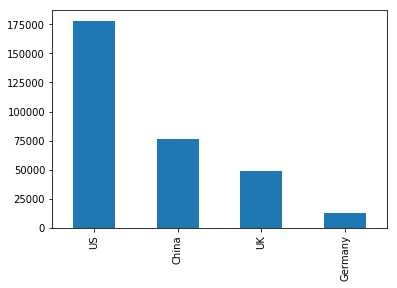

In [9]:
data.country.value_counts().plot(kind='bar')

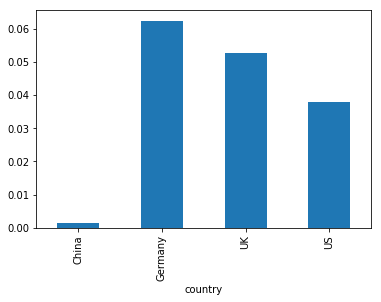

In [10]:
convert_country = data.groupby('country').converted.mean()
convert_country.plot(kind='bar')

From above, we can see that users from China has the lowest conversion rate, although the number of users from China ranks two.
For UK and Germany, they has the fewest number of users but highest conversion rates.

Now, let's check the relationship between total_pages_visited with conversion rate.

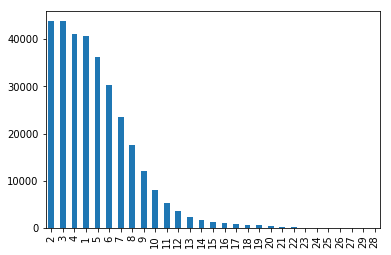

In [11]:
data.total_pages_visited.value_counts().plot(kind='bar')

From the below, we can see that with the increasement of total_pages_visited, the conversion rate increases. This is quite noraml, cause if we read more webpages, we are more intersted in the content on the pages and more willing to pay for it.

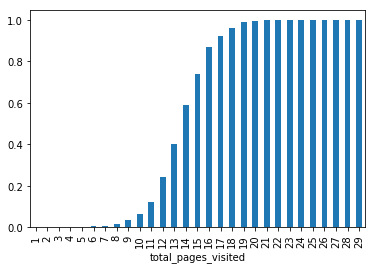

In [12]:
convert_pages = data.groupby('total_pages_visited').converted.mean()
convert_pages.plot(kind='bar')

Last, we check the relationship between ages and conversion rate.

In [13]:
convert_ages = data.groupby('age').converted.mean()
temp = pd.DataFrame(convert_ages)

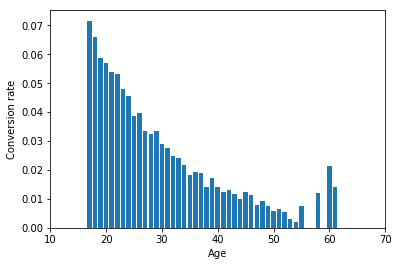

In [14]:
plt.bar(temp.index, temp.converted)
plt.xlim(10, 70)
plt.xlabel('Age')
plt.ylabel('Conversion rate')
plt.show()

We can see that with the increasing of ages, the conversion rate decreases and it seems that if users are older than 65, none of them will go to pay.

## Data Processing
Since we have some categorical, like country and source, we need to converge them to cagtegorical variable. 
We can use the One-hot encoding to transform them.

In [15]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [16]:
X = pd.get_dummies(X)

In [17]:
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [18]:
y.value_counts()

0    306000
1     10198
Name: converted, dtype: int64

From above, we can seet that the distribution of y is very imbalance.

## Build model
Since it is an classification problem, I choose Logistic Regression and Decision Tree as our models, in considertaion of the interpretability.

In [19]:
lr = LogisticRegressionCV(Cs=np.logspace(-4, 4, 7), cv=5, dual=False,
                         max_iter=1000, n_jobs=-1, verbose=1)

In [20]:
lr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.9s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.8s finished


LogisticRegressionCV(Cs=array([1.00000e-04, 2.15443e-03, 4.64159e-02, 1.00000e+00, 2.15443e+01,
       4.64159e+02, 1.00000e+04]),
           class_weight=None, cv=5, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring=None, solver='lbfgs', tol=0.0001, verbose=1)

Now, let's first look at the report of out first logistic regression model.

In [21]:
y_pred = lr.predict(X_test)

In [22]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     91746
          1       0.85      0.68      0.75      3114

avg / total       0.98      0.99      0.98     94860



From above, we can see that the metrics for target=0 are perfect, while for target=1, it's not good. This may due to the imbalance data.
Next, we try to balance the data. Using SMOTE may help.

In [28]:
sm = SMOTE(random_state=3)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [29]:
lr2 = LogisticRegressionCV(Cs=np.logspace(-4, 4, 7), cv=5, dual=False,
                         max_iter=1000, n_jobs=-1, verbose=1)
lr2.fit(X_train_res, y_train_res)
y_pred = lr2.predict(X_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.5s remaining:   17.3s


             precision    recall  f1-score   support

          0       1.00      0.94      0.97     91746
          1       0.36      0.94      0.52      3114

avg / total       0.98      0.94      0.95     94860



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished


From above, the recall increases a lot, but precision decrease significantly.

In [ ]:
lr2 = LogisticRegressionCV(Cs=np.logspace(-4, 4, 7), cv=5, dual=False,
                         max_iter=1000, n_jobs=-1, verbose=1)
lr2.fit(X_train_res, y_train_res)
y_pred = lr2.predict(X_test)
print(classification_report(y_test, y_pred))

In [50]:
lr3 = LogisticRegressionCV(Cs=np.logspace(-4, 4, 7), cv=5, dual=False,
                         max_iter=1000, n_jobs=-1, verbose=1)
lr3.fit(np.vstack((X_train_res, X_train)), np.r_[y_train, y_train_res])
y_pred = lr3.predict(X_test)
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.4s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.4s finished


             precision    recall  f1-score   support

          0       0.96      0.74      0.84     91746
          1       0.00      0.00      0.00      3114

avg / total       0.93      0.72      0.81     94860

